In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
data_path = "./dane/"
df = pd.read_csv(os.path.join(data_path, "szer.csv"), sep=';')
df = df.drop("KR", axis=1)

In [3]:
# wartość optymalizacji po poszczególnym ruchu
optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])
Neighbours_count = 20
improvements = np.zeros(Neighbours_count)

In [4]:
# KR to wartość naszego rozwiązania - ma być najmniejsza
def E(df = df):
    c_sum = df["Czas wykonania"].cumsum() # suma kumultatywna kolumny "Czas wykonania"
    KR = (df["Termin"] - c_sum)**2 # obliczanie kwadratu różnicy wartosći
    return sum(KR) # KR jest wskaźnikiem jakości ułożenia zadań. To optymalizujemy

# wyszukiwanie listy sąsiadów
def get_neighbours(idx, neighbours_count = 20, df = df):
    N = neighbours_count
    # Idea sąsiedztwa dla N = 6 i idx = n E <N/2 ; L-N/2>
    # idx = X, sąsiad = 0, nie sąsiad = -
    # nr_indeksu | ... | n-4 | n-3 | n-2 | n-1 |  n  | n+1 | n+2 | n+3 | n+4 | ... |
    # sasiedztwo |  -  |  -  |  0  |  0  |  0  |  X  |  0  |  0  |  0  |  -  |  -  |
    
    L = len(df) - 1 
    idx_prev = idx # indeks dla ktorego szukamy sasiadow
    N_half = N//2 # polowa wartosci N
    
    # Idea sąsiedztwa dla N = 6 i idx = n < N/2
    # idx = X, sąsiad = 0, nie sąsiad = -
    # przykład n = 2
    # nr_indeksu |  0  |  1  | n=2 |  3  |  4  |  5  |  6  |  7  |  8  |  9  | ... |
    # sasiedztwo |  0  |  0  |  X  |  0  |  0  |  0  |  0  |  -  |  -  |  -  |  -  |
    # skoro nie mozemy znaleźć wystarczająco dużo sąsiadów po lewej, 
    # szukamy dodatkowego po prawej
    if idx < N_half:
        idx = N_half
    # idea sąsiedztwa z ograniczeniem z prawej jest analogiczna do tej z ograniczeniem z lewej
    elif idx > L - N_half:
        idx = L - N_half
    output = list(range(idx - N_half, idx + N_half + 1))
    # usuwanie idx z output
    # TODO: na pewno da się to zrobić prościej
    rm_idx = output.index(idx_prev)
    output = np.array(output)
    output = np.delete(output, rm_idx)
    return output

def swap(idx_1, idx_2, df=df):
    # zamiana miejscami dwóch wierszy "in place" - nie tworzymy nowej ramki danych
    df.iloc[idx_1], df.iloc[idx_2] = df.iloc[idx_2].copy(), df.iloc[idx_1].copy()
    
def move(idx_1, idx_2, df=df):
    swap(idx_1, idx_2) # ruch

def reduce_temperature(T, rate_of_change = .02, sposob = 1):
    return (1-rate_of_change)*T if sposob == 1 else T/(1+rate_of_change*T)

def plot_optimalization(optimalization):
    # TODO: można to zrobić ładniej matplotlibem
    optimalization["Wartosc kombinacji"].plot(kind="line")



In [5]:
R = np.random.randint(len(df)) # losowy numer wiersza
neighbour = get_neighbours(idx=R, neighbours_count=20) # generuj sąsiadów


In [12]:
def simulated_anniling_algorithm(
    T = 2500, 
    Tmin = 100, 
    neighbours_count=20, 
    number_of_generations = 1000
):
    global df
    np.random.seed(42)
    R = np.random.randint(len(df)) # losowy numer wiersza
    optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])
    while T > Tmin:
         
        while number_of_generations:
            print(f"{number_of_generations} iterations left.")
            KR_before = E()
            neighbours = get_neighbours(idx=R, neighbours_count=neighbours_count) # generuj sąsiadów
            R_prim = np.random.choice(neighbours) # losowy indeks wiersza
            move(R, R_prim)
            KR_now = E()
            dE = KR_now - KR_before
                        # prawdopodobieństwo przyjęcia gorszego rozwiązania
            if dE < 0 or np.random.rand() < np.exp(-dE/T):
                R = R_prim

            # dodawanie obecnej wartości kombinacji do listy wszystkich wartości
            optimalization = optimalization.append({
                    "Wartosc kombinacji": KR_now
                }, ignore_index=True)
            number_of_generations -= 1
        T = reduce_temperature(T)
    order = df["Zadanie"]
    return order, optimalization
            

In [30]:
%%time
new_order, new_optimalization = simulated_anniling_algorithm(
    T = 2500, 
    Tmin = 100, 
    neighbours_count=6, 
    number_of_generations = 1000)

1000 iterations left.
999 iterations left.
998 iterations left.
997 iterations left.
996 iterations left.
995 iterations left.
994 iterations left.
993 iterations left.
992 iterations left.
991 iterations left.
990 iterations left.
989 iterations left.
988 iterations left.
987 iterations left.
986 iterations left.
985 iterations left.
984 iterations left.
983 iterations left.
982 iterations left.
981 iterations left.
980 iterations left.
979 iterations left.
978 iterations left.
977 iterations left.
976 iterations left.
975 iterations left.
974 iterations left.
973 iterations left.
972 iterations left.
971 iterations left.
970 iterations left.
969 iterations left.
968 iterations left.
967 iterations left.
966 iterations left.
965 iterations left.
964 iterations left.
963 iterations left.
962 iterations left.
961 iterations left.
960 iterations left.
959 iterations left.
958 iterations left.
957 iterations left.
956 iterations left.
955 iterations left.
954 iterations left.
953 iteratio

582 iterations left.
581 iterations left.
580 iterations left.
579 iterations left.
578 iterations left.
577 iterations left.
576 iterations left.
575 iterations left.
574 iterations left.
573 iterations left.
572 iterations left.
571 iterations left.
570 iterations left.
569 iterations left.
568 iterations left.
567 iterations left.
566 iterations left.
565 iterations left.
564 iterations left.
563 iterations left.
562 iterations left.
561 iterations left.
560 iterations left.
559 iterations left.
558 iterations left.
557 iterations left.
556 iterations left.
555 iterations left.
554 iterations left.
553 iterations left.
552 iterations left.
551 iterations left.
550 iterations left.
549 iterations left.
548 iterations left.
547 iterations left.
546 iterations left.
545 iterations left.
544 iterations left.
543 iterations left.
542 iterations left.
541 iterations left.
540 iterations left.
539 iterations left.
538 iterations left.
537 iterations left.
536 iterations left.
535 iteration

145 iterations left.
144 iterations left.
143 iterations left.
142 iterations left.
141 iterations left.
140 iterations left.
139 iterations left.
138 iterations left.
137 iterations left.
136 iterations left.
135 iterations left.
134 iterations left.
133 iterations left.
132 iterations left.
131 iterations left.
130 iterations left.
129 iterations left.
128 iterations left.
127 iterations left.
126 iterations left.
125 iterations left.
124 iterations left.
123 iterations left.
122 iterations left.
121 iterations left.
120 iterations left.
119 iterations left.
118 iterations left.
117 iterations left.
116 iterations left.
115 iterations left.
114 iterations left.
113 iterations left.
112 iterations left.
111 iterations left.
110 iterations left.
109 iterations left.
108 iterations left.
107 iterations left.
106 iterations left.
105 iterations left.
104 iterations left.
103 iterations left.
102 iterations left.
101 iterations left.
100 iterations left.
99 iterations left.
98 iterations 

In [31]:
print(new_optimalization)
print(new_order)

    Wartosc kombinacji
0               672501
1               672517
2               672429
3               672517
4               672990
..                 ...
995             696639
996             695299
997             694920
998             693216
999             692948

[1000 rows x 1 columns]
0     35
1     34
2     29
3     21
4     14
      ..
75    60
76    32
77    77
78    41
79    55
Name: Zadanie, Length: 80, dtype: int64


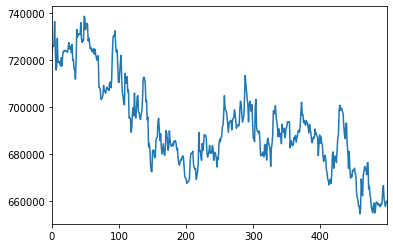

In [25]:
plot_optimalization(new_optimalization)